# BYO Cluster Model

In [28]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
%matplotlib inline

In [29]:
# Load in 2014 data
df = pd.read_csv('https://github.com/llimllib/bostonmarathon/raw/master/results/2014/results.csv')
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


## 1. Data cleaning

In [30]:
list(df.columns)

['10k',
 'name',
 'division',
 '25k',
 'gender',
 'age',
 'official',
 'bib',
 'genderdiv',
 'ctz',
 '35k',
 'overall',
 'pace',
 'state',
 '30k',
 '5k',
 'half',
 '20k',
 'country',
 'city',
 '40k']

In [31]:
# Drop columns not related to performance.
df = df.drop(columns=['name', 'bib', 'ctz', 'state','country','city'])

# Remove hyphens from missing entries
df = df.replace(to_replace='-', value='')


In [32]:
#make gender numeric
gender = {'M': 1,'F': 0}
df.gender = [gender[item] for item in df.gender]

In [33]:
df.gender.value_counts()

1    17617
0    14367
Name: gender, dtype: int64

In [34]:
df.dtypes

10k           object
division       int64
25k           object
gender         int64
age            int64
official     float64
genderdiv      int64
35k           object
overall        int64
pace         float64
30k           object
5k            object
half          object
20k           object
40k           object
dtype: object

In [35]:
# Looks like we have a lot of objects where we should have numbers. Lets convert all race stage columns to numbers
races = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']
for race in races:
    df[race] = pd.to_numeric(df[race], errors='coerce')



In [36]:
df.dtypes

10k          float64
division       int64
25k          float64
gender         int64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
half         float64
20k          float64
40k          float64
dtype: object

In [37]:
#check size of data
df.shape

(31984, 15)

In [38]:
df.isnull().sum()

10k           50
division       0
25k          216
gender         0
age            0
official       0
genderdiv      0
35k           34
overall        0
pace           0
30k           40
5k            52
half          72
20k           51
40k           39
dtype: int64

In [39]:
#drop null values
df = df.dropna()

In [50]:
# That's a big dataset. let's split it into smaller sets so our models run faster

# First, specify what we want to evaluate - use 10K as split method
X = df1.loc[:, ['10k', '20k', '30k', '40k', 'overall']]
X_norm = normalize(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)
# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

791 791
791 791
791 791
791 791


## 2. Clustering Models

In [42]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## 2a K-means

In [52]:
# Run k means model
for k in np.arange(2, 7, 1):
    model = KMeans(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.9490132196805277
K: 3, silhouette: 0.9046569578896211
K: 4, silhouette: 0.8676181730422373
K: 5, silhouette: 0.8072241470971723
K: 6, silhouette: 0.7894699301402841


## 2b Mean-shift

In [53]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set bandwidth estimator
bandwidth = estimate_bandwidth(X_norm, quantile=0.2, n_samples=500)

# Declare and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_norm)

# Get labels, number of clusters, similarity score
labels = ms.labels_
n_clusters = len(np.unique(labels))
silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
print('K: {}, silhouette: {}'.format(n_clusters, silhouette))

K: 28, silhouette: 0.8208318952276671


## 2c Spectral

In [54]:
from sklearn.cluster import SpectralClustering

# Run spectral clustering over range of k values
for k in np.arange(2, 4, 1):
    sc = SpectralClustering(n_clusters=k, random_state=42).fit(X_norm)
    labels = model.labels_
    silhouette = metrics.silhouette_score(X_norm, labels, metric='euclidean')
    print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.7894699301402841
K: 3, silhouette: 0.7894699301402841


## 2d Affinity Propogation

In [55]:
from sklearn.cluster import AffinityPropagation

# Run and fit model
af = AffinityPropagation().fit(X_norm)

# Get number of clusters
cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('K: {}'.format(n_clusters))

K: 1696


Overall, the silhouette scores for the four-cluster solutions were highest for the k-means models.

# 3. Model Vizualiation

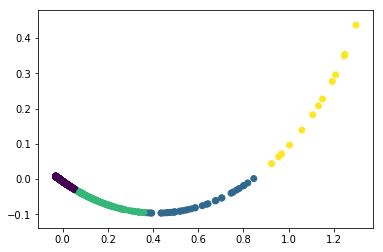

In [61]:
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
km = KMeans(n_clusters=4, random_state=42).fit(X_pca)
labels = km.labels_
X['cluster'] = labels
# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X['cluster'])
plt.show()

In [63]:
# Summary stats, overall time by cluster
X.groupby(['cluster'])['overall'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2965.0,17148.710961,8655.807460,2067.0,9677.0,17343.0,24755.00,31874.0
1,38.0,282.894737,87.975055,151.0,202.5,287.0,340.50,456.0
2,148.0,1301.527027,453.222632,454.0,922.5,1311.5,1682.75,2097.0
3,13.0,61.153846,38.757464,2.0,33.0,57.0,97.00,121.0


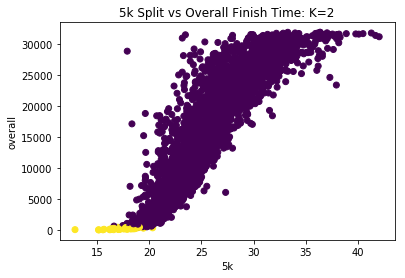

In [65]:
# Plot 5k split vs overall finish
plt.scatter(df1['5k'], df1['overall'], c=df1['cluster'])
plt.xlabel('5k')
plt.ylabel('overall')
plt.title('5k Split vs Overall Finish Time: K=2')
plt.show()

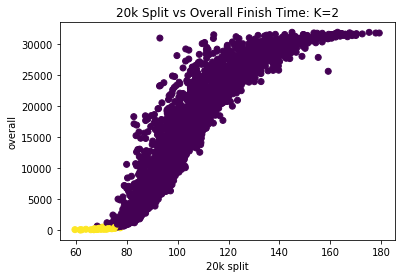

In [66]:
# Plot 20k split vs overall finish time
plt.scatter(df1['20k'], df1['overall'], c=df1['cluster'])
plt.xlabel('20k split')
plt.ylabel('overall')
plt.title('20k Split vs Overall Finish Time: K=2')
plt.show()